# Векторизация текста и измерение семантического сходства

<b>Цель</b>: В данном ноутбуке я тестирую программные методы представления текстов в виде векторов и их семнтического (по смыслу) сравнения. 

<b>Задачи:</b>
- векторизаия абстрактов статей в вектора;
- вычисление косинусного сходства между этими векторами;
- визуализация смысловой «похожести» текстов

In [2]:
# ипортируем нужные библиотеки
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
import sentence_transformers.util as st_util
tqdm.pandas()  # sets tqdm to notebook mode
import matplotlib.pyplot as plt

## 1. Считывание данных

Результаты прошлого этапа работы (препроцессинг) у нас сохранены в `"preprocessed_abstracts.csv"`. Нам в этом файле особенно интересны следующие столбцы:

- `title` - оригинальные заголовки cтатей;
- `summary` - оригинальные абстракты статей;
- `summary_tokens` - очищенные от лишних знаков, стоп-слов и лемматизированные абстракты статей; 
- `title_tokens` -  - очищенные от лишних знаков, стоп-слов и лемматизированные заголовки cтатей; 
- `tokens_combined` - склеенные очищенные и лемматизированные заголовки и абстракты статей.

Поскольку мы пока что работаем с малыми данными, файл содержит первую 1000 записей метаданных в категории arxiv.org `astro-ph.IM`.

In [3]:
df = pd.read_csv('preprocessed_abstracts.csv')

In [4]:
df.head()

,id,updated,published,title,summary,author,doi,link_related,comment,journal_ref,link_alternate,primary_category,category,author.name,author.affiliation,summary_tokens,title_tokens,tokens_combined
0,http://arxiv.org/abs/astro-ph/0407044v1,2004-07-02T10:17:39Z,2004-07-02T10:17:39Z,Muon Track Reconstruction and Data Selection T...,The Antarctic Muon And Neutrino Detector Array...,"[{'name': 'The AMANDA Collaboration'}, {'name'...",10.1016/j.nima.2004.01.065,['http://dx.doi.org/10.1016/j.nima.2004.01.065...,"40 pages, 16 Postscript figures, uses elsart.sty","Nucl.Instrum.Meth.A524:169-194,2004",http://arxiv.org/abs/astro-ph/0407044v1,astro-ph,"['astro-ph', 'astro-ph.IM']",NaN,NaN,"['Antarctic', 'Muon', 'Neutrino', 'Detector', ...","['Muon', 'Track', 'Reconstruction', 'Data', 'S...","['Muon', 'Track', 'Reconstruction', 'Data', 'S..."
1,http://arxiv.org/abs/astro-ph/0410439v1,2004-10-19T14:47:51Z,2004-10-19T14:47:51Z,An update on the SCUBA-2 project,"SCUBA-2, which replaces SCUBA (the Submillimet...","[{'name': 'Michael Audley', 'affiliation': 'UK...",10.1117/12.551259,"['http://dx.doi.org/10.1117/12.551259', 'http:...","16 pages, 14 figures, Invited talk at SPIE Gla...",NaN,http://arxiv.org/abs/astro-ph/0410439v1,astro-ph,"['astro-ph', 'astro-ph.IM']",NaN,NaN,"['replace', 'SCUBA', 'Submillimeter', 'Common'...","['update', 'project']","['update', 'project', 'replace', 'SCUBA', 'Sub..."
2,http://arxiv.org/abs/astro-ph/0411574v3,2011-01-05T18:55:32Z,2004-11-19T15:00:42Z,Feasibility study of a Laue lens for hard X-ra...,We report on the feasibility study of a Laue l...,"[{'name': 'A. Pisa', 'affiliation': 'Universit...",10.1117/12.563052,"['http://dx.doi.org/10.1117/12.563052', 'http:...","10 pages, corrected Fig. 1b and Fig. 2, which ...","SPIE Proc., 5536, 39 (2004)",http://arxiv.org/abs/astro-ph/0411574v3,astro-ph,"['astro-ph', 'astro-ph.IM']",NaN,NaN,"['report', 'feasibility', 'study', 'Laue', 'le...","['feasibility', 'study', 'Laue', 'lens', 'hard...","['feasibility', 'study', 'Laue', 'lens', 'hard..."
3,http://arxiv.org/abs/astro-ph/0504497v1,2005-04-22T12:39:07Z,2005-04-22T12:39:07Z,Search for Extra-Terrestrial planets: The DARW...,The DARWIN mission is an Infrared free flying ...,NaN,NaN,http://arxiv.org/pdf/astro-ph/0504497v1,"PhD thesis 2004, Karl Franzens Univ. Graz, 177...",NaN,http://arxiv.org/abs/astro-ph/0504497v1,astro-ph,"['astro-ph', 'astro-ph.EP', 'astro-ph.IM']",Lisa Kaltenegger,NaN,"['DARWIN', 'mission', 'Infrared', 'free', 'fly...","['search', 'extra', 'terrestrial', 'planet', '...","['search', 'extra', 'terrestrial', 'planet', '..."
4,http://arxiv.org/abs/physics/0510224v1,2005-10-25T15:36:07Z,2005-10-25T15:36:07Z,Wavefront sensor based on varying transmission...,The use of Wavefront Sensors (WFS) is nowadays...,NaN,10.1080/09500340500073495,['http://dx.doi.org/10.1080/09500340500073495'...,"2 tables, 6 figures","J.Mod.Opt. 52:1917-1931,2005",http://arxiv.org/abs/physics/0510224v1,physics.optics,"['physics.optics', 'astro-ph', 'astro-ph.IM']",Francois Henault,NaN,"['use', 'Wavefront', 'Sensors', 'WFS', 'nowada...","['wavefront', 'sensor', 'base', 'vary', 'trans...","['wavefront', 'sensor', 'base', 'vary', 'trans..."


## 2. Методология: факторы, которые я учитываю при работе с данными

### Выходные данные для используемых методов

В рамках этого ноутбука я пробую работать как с классическими методами, такими как TF-IDF, BoW, так и с эмбеддингами. Эти подходы могут быть по-разному чувствительны к форме данных, подаваемых на вход:
 
1. "Классические" методы TF-IDF, BoW чувствительны к частоте и форме слов, поэтому важно подавать им предобработанные данные, чтобы модели не сбились;
2. Эмбеддинги (такие как SentenceTransformer) могут (но не обязательно будут) лучше работать на оригинальных текстах, в которых: 
- данные не лемматизированы до потери контекста;
- оставлены знаки пунктуации, помогающие модели понять структуру предложений
- оставлены важные для контекста единицы измерения, например `10^15 eV`.

Поэтому методам из 1 мы будем подавать на вход "чистые данные", а методам из 2. попробуем подать и чистые и сырые и сравним, что будет лучше работать.

### Комбинирование данных в разных столбцах

Для нашего исследования имеет смысл использовать и заголовки статей (отражают тематику и тип исследования), и их абстракты (содержат методы, данные, результаты и проч. детальный контекст). При этом возниает вопрос: векторизовать и семантически сравнивать это данные по отдельности и потом как-то вычислять общую оценку или склеивать всё вместе и производить все вычисления только один раз? Рассмотрим следующие 

#### Возможные подходы к объединению заголовков и аннотаций

Введём <b>Определение.</b>

Embedding, он же "векторное представление" — это способ представить смысл текста в виде чисел.
То есть мы превращаем слова, предложения или документы в векторы — точки в многомерном пространстве, где смысловые сходства превращаются в геометрические расстояния.

Embedding — это результат работы обученной модели (например, SentenceTransformer), которая отображает текст в векторное пространство признаков.
В этом пространстве:
- близкие тексты (например, “proton flux” и “cosmic ray spectrum”) имеют маленькое косинусное расстояние (угол между векторами маленький);
- разные тексты (например, “neural network training” и “gamma-ray observatory”) — находятся далеко друг от друга.

Когда у нас есть как заголовки статей, так и аннотации, существует несколько способов вычисления семантического сходства:

1. **Конкатенация**
- Объединить заголовок и аннотацию в один текст перед векторизацией (эмбеддингом)
- Это простой способ, позволяющий модели автоматически сбалансировать значение.

2. **Взвешенное среднее эмбеддингов (векторных представлений)**
- Вычислить отдельно эмбеддинги для заголовка и аннотации, затем взять взвешенное среднее:
`combined_emb = w_title * title_emb + w_abstract * abstract_emb`
- Позволяет контролировать влияние заголовка по сравнению с аннотацией.
- Приводит нас к вопросу того, какие веса `w_title` и `w_abstract` имеют смысл в нашей задаче.

3. **Взвешенные оценки схожести**
- Производится отдельно не только векторизация, но вычисление косинуснуой схожести для названий и аннотаций:
`sim_title = cosine_similarity(title_emb)`
`sim_abstract = cosine_similarity(abstract_emb)`
- Далее вычисляется взвешенная косинусная схожесть:
`combined_sim = alpha * sim_title + (1-alpha) * sim_abstract`
- Гибкий подход, позволяет по необходимости уделять больше внимания заголовку или аннотации
- Нужно пробовать разные параметры `alpha`.

4. **Двухэтапный поиск (для RAG / классификаторов)**
- Использование схожести заголовков для быстрой фильтрации.
- Использование схожести аннотаций для более точного ранжирования.
- Может пригодиться нам на более поздних этапах проекта.

### Используемые методы

В этом ноутбуке я рассматриваю альтернативные методы решения одной задачи:
- <b>TF-IDF</b> - “bag-of-words” с весами для слов.
- <b>Sentence Transformers</b> - “умный” вектор всего текста, учитывающий смысл.

Цель: сравнить, как они работают. Ожидаем, что TF-IDF покажет “поверхностное” сходство по ключевым словам, а эмбеддинги — глубокое, семантическое сходство.

#### Общее у этих методов
И TF-IDF, и Sentence Transformers создают векторное представление текста — то есть превращают текст в числовой вектор, который можно использовать для:
- измерения сходства между документами,
- кластеризации,
- поиска похожих текстов,
- машинного обучения.

#### Особенности TF-IDF
- Простой, быстрый, хорошо работает на небольших корпусах.
- Показывает, какие слова важны для документа, но не улавливает семантический смысл (например, “car” и “automobile” будут считаться разными словами).
- В выходных данных длина ветора для текста будет равна числу уникальных слов в тексте (т.е., мб разная для каждого слова в тексте)
- Принцип работы
<ul>
    <li>Каждое слово - отдельное измерение в векторе.</li>
<li>Вес слова = TF × IDF.</li>
<li> Игнорируется порядок слов, контекст слова в предложении почти не учитывается.</li>
    </ul>

#### Особенности Семантических эмбеддингов (Sentence Transformers)
- Нейросетевой метод,использующий предобученные модели (например, `all-MiniLM-L6-v2`).
- Превращает весь текст (фразу, предложение, абстракт) в компактный вектор фиксированной размерности (например, 384 или 768)
- Вектор документа на выходе всегда фиксированной длины, независимой от числа слов в корпусе - можно сравнивать тексты разной длины
- Даёт более точную оценку смыслового сходства.
- Требует больше ресурсов для вычислений

## Векторизация через TF-IDF


###  Теория

<b>Определение.</b> TF-IDF расшифровывается как Term Frequency – Inverse Document Frequency. Этот параметр показывает, насколько слово важно в конкретном документе по сравнению со всей коллекцией текстов.

Он вычисляется по следующей формуле:
**TF-IDF:**
$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

где:  
- $t$ — термин (слово или токен)  
- $d$ — документ (абстракт)
- $N$ — общее количество документов (в нашем сэмпле их 1000)
- $n_t$ — количество документов, в которых встречается термин $t$ (например, слово `CORSIKA`) 
- $\text{TF}(t, d)$ — частота слова $t$ в документе $d$,  
- $\text{IDF}(t)$ — обратная частота документа для слова $t$.

Член $\text{TF}(t, d)$ называется `Term Frequency` и показывает, насколько часто слово встречается в документе. его рассчитывают вот так:

$$
\text{TF}(t, d) = \frac{f_{t,d}}{\sum_{k} f_{k,d}}
$$

где:  
- $f_{t,d}$ - это частота (frequency) того, сколько раз термин $t$ встречается в документе \(d\)  
- знаменатель $\sum_{k} f_{k,d}$ это сумма по всем токенам текста сколько раз тот или иной токен встречается в тексте, т.е. общее количество всех слов в документе 

Член $$\text{IDF}(t) = \log \frac{N}{n_t}$$

где:  
- $N$ — общее число документов  
- $n_t$ — количество документов, содержащих термин $t$

называется `Inverse Document Frequency`, aka `обратная частота документа` и показывает, насколько редким является токен $t$ в документе $d$. Как именно это работает:

- Если слово встречается почти в каждом документе,  
$$
\frac{N}{n_t} \approx 1
$$
и тогда  
$$
\log(1) = 0
$$
-> значение IDF близко к нулю.

- Если слово встречается редко (например, только в одном документе),  
$$
\frac{N}{n_t}
$$
будет большим,  
и, следовательно, IDF также будет высоким:
$$
\text{IDF}(t) = \log \frac{N}{n_t}
$$

Моя интуиция мне подсказывает, что не обязательно все редкие слова будут прямо такими значимыми в тексте, какие-то из них там могут оказаться по ошибке, из-за того, что текст писал нэтивспикер, прихвастнувший богатыми познаниями в языке и т.д. И именно эту проблему адресует использование общей формулы $TF-IDF$.

#### Интерпретация $TF-IDF$

- Если слово часто встречается **внутри конкретного документа**, то $\text{TF}(t, d)$ большое.  
- Если слово встречается **во многих документах корпуса**, то $\text{IDF}(t)$ маленькое.  
- Если слово встречается **редко в корпусе**, то $\text{IDF}(t)$ большое.
- Таким образом, высокий вес TF-IDF получают слова, которые: 1) часто встречаются в данном документе; 2) редки в остальных документах корпуса. Т.е., часть IDF определяет уникальность слова в корпусе, а часть TF позволяет понять, случайно оно оказалось в конкретном тексте, или это паттерн и это слово действительно важно и глубоко этот текст характеризует.

### Практика

In [5]:
vectorizer = TfidfVectorizer() 
data1 = df['tokens_combined'] #подаём модели на вход "чистые" данные, загловки и абстракты вместе
X_tfidf = vectorizer.fit_transform(data1) 
similarity_tfidf = cosine_similarity(X_tfidf) 
print(similarity_tfidf)

[[1.         0.05093006 0.01810029 ... 0.03435735 0.03578445 0.00861096]
 [0.05093006 1.         0.00877696 ... 0.06212513 0.03667298 0.03183584]
 [0.01810029 0.00877696 1.         ... 0.01824259 0.02726266 0.00342599]
 ...
 [0.03435735 0.06212513 0.01824259 ... 1.         0.06269931 0.00315914]
 [0.03578445 0.03667298 0.02726266 ... 0.06269931 1.         0.0157325 ]
 [0.00861096 0.03183584 0.00342599 ... 0.00315914 0.0157325  1.        ]]


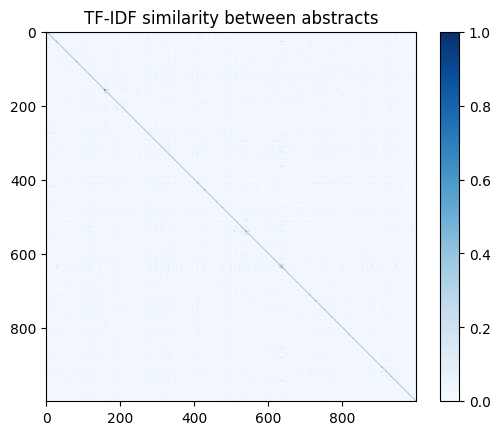

In [6]:
plt.imshow(similarity_tfidf, cmap='Blues')  # с визуализацией не задалось, ведь вектора у нас разной длины. 
#вернусь к этому, если оно в будущем будет полезно
plt.title("TF-IDF similarity between abstracts") 
plt.colorbar() 
plt.show()

Поскольку график выглядит пустым, попробуем раздебажить визуализацию.

Моя первая гипотеза была, что матрицу сходства вообще нельзя нарисовать, потому что TF-IDF для каждого текста генерирует вектора разной длины. Но это не так, потому что выход из функции `cosine_similarity(X_tfidf)` уже квадратный и должен нормально рисоваться.

Другие возможные причины:
- Все значения сходства слишком малы (например, < 0.05).
- Цветовая шкала cmap='Blues' недостаточно контрастная.

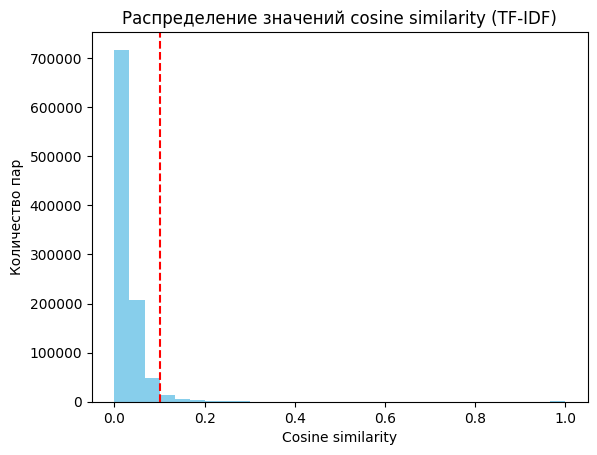

In [7]:
# проверим распределение значений в матрице:
threshold=0.1
plt.hist(similarity_tfidf.flatten(), bins=30, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Распределение значений cosine similarity (TF-IDF)")
plt.xlabel("Cosine similarity")
plt.ylabel("Количество пар")
plt.show()

Т.е., действительно значения косинусного сходства очень маленькие. Почему?
#### Возможные причины низкого сходства TF-IDF

1. Очень разные словари текстов: у текстов почти нет общих лемм, даже после очистки. Особенно актуально, если тексты из разных тематик или доменов.
2. Короткие тексты. Мало слов → слабое пересечение → малая косинусная схожесть.
3. Сильная лемматизация или очистка. Агрессивная фильтрация (удалены редкие/служебные слова, числительные, сокращения) может стереть контекст.
4. Проблема синонимов в TF-IDF: метод думает, что это разные слова. Что приводит к разраженности итоговой матрицы сходства
5. Большой корпус. Если N (число документов) велико, IDF для многих слов мал, а веса становятся близкими к нулю.

5 точно не наш случай, остальное будет проверять.

In [8]:
# проверим гипотезу 4
nonzero_per_doc = (X_tfidf > 0).sum(axis=1).A1  # количество ненулевых элементов на документ
avg_nonzero = np.mean(nonzero_per_doc)
total_elements = X_tfidf.shape[0] * X_tfidf.shape[1]
nonzero_total = X_tfidf.nnz
sparsity = 1 - (nonzero_total / total_elements)

print(f"Среднее число ненулевых элементов на документ: {avg_nonzero:.1f}")
print(f"Всего элементов: {total_elements:,}")
print(f"Ненулевых элементов: {nonzero_total:,}")
print(f"Разреженность: {sparsity:.3%}")

Среднее число ненулевых элементов на документ: 67.5
Всего элементов: 7,695,000
Ненулевых элементов: 67,544
Разреженность: 99.122%


Как можно видеть, разреженность у нас просто катастрофическая. Её можно чинить через:
- выкидвание стоп-слов (уже сделано)
- ограничение размера словаря (`vectorizer = TfidfVectorizer(max_features=5000)`)
- биграммы или триграммы   <span style="color:blue">(а что это вообще такое?)</span>

In [9]:
# проверим корректность обработки токенов при передаче в TfidfVectorizer
print(data1[0][:200])

['Muon', 'Track', 'Reconstruction', 'Data', 'Selection', 'Techniques', 'AMANDA', 'Antarctic', 'Muon', 'Neutrino', 'Detector', 'Array', 'AMANDA', 'high', 'energy', 'neutrino', 'telescope', 'operate', '


In [10]:
vectorizer.get_feature_names_out()[:100]

array(['aaac', 'aachen', 'aal', 'aao', 'aaomega', 'aapf', 'aas', 'ab',
       'abcd', 'abell', 'aberrated', 'aberration', 'ability', 'able',
       'aboard', 'abolish', 'abridge', 'abridged', 'abroad', 'abruptly',
       'abs', 'abscissa', 'absence', 'absent', 'absolute', 'absolutely',
       'absorb', 'absorbance', 'absorber', 'absorption', 'abstract',
       'abu', 'abundance', 'abundances', 'abundant', 'abyss', 'academic',
       'academy', 'acbar', 'acc', 'accelerate', 'accelerated',
       'accelerateur', 'acceleration', 'accelerator', 'accelerators',
       'accelerometer', 'accept', 'acceptable', 'acceptance', 'access',
       'accessibility', 'accessible', 'accidental', 'accidentally',
       'accommodate', 'accompany', 'accomplish', 'accord', 'accordance',
       'accordingly', 'account', 'accounting', 'accrete', 'accretion',
       'accrue', 'accumulate', 'accuracy', 'accurate', 'accurately',
       'acd', 'achievable', 'achieve', 'achievement', 'achievment',
       'achromat

[[1.         0.30713356 0.03011855 ... 0.13073654 0.22652    0.05464508]
 [0.30713356 1.         0.10944507 ... 0.43335922 0.11438032 0.06211314]
 [0.03011855 0.10944507 1.         ... 0.12203245 0.21218473 0.        ]
 ...
 [0.13073654 0.43335922 0.12203245 ... 1.         0.24555472 0.03954395]
 [0.22652    0.11438032 0.21218473 ... 0.24555472 1.         0.03574637]
 [0.05464508 0.06211314 0.         ... 0.03954395 0.03574637 1.        ]]


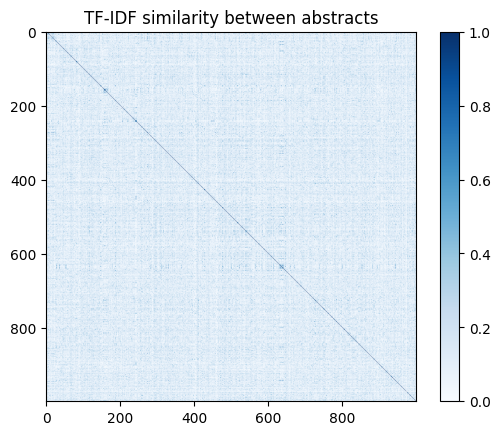

In [11]:
# попробуем сделать то же самое, но с ограниченным размером словаря (max_features=100)
vectorizer_1 = TfidfVectorizer(max_features=100) 
data1 = df['tokens_combined'] #подаём модели на вход "чистые" данные, загловки и абстракты вместе
X_tfidf_1 = vectorizer_1.fit_transform(data1) 
similarity_tfidf_1 = cosine_similarity(X_tfidf_1) 
print(similarity_tfidf_1)
plt.imshow(similarity_tfidf_1, cmap='Blues')  # с визуализацией не задалось, ведь вектора у нас разной длины. 
#вернусь к этому, если оно в будущем будет полезно
plt.title("TF-IDF similarity between abstracts") 
plt.colorbar() 
plt.show()

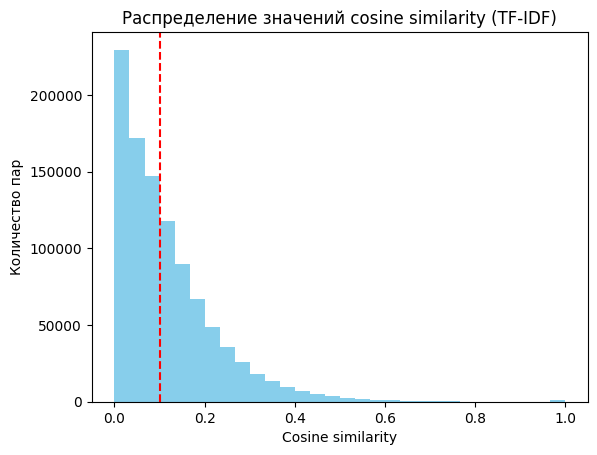

In [12]:
# проверим распределение значений в матрице:
threshold=0.1
plt.hist(similarity_tfidf_1.flatten(), bins=30, color='skyblue')
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Распределение значений cosine similarity (TF-IDF)")
plt.xlabel("Cosine similarity")
plt.ylabel("Количество пар")
plt.show()

Как можно видеть, графики стали более интересными. Посмотрим, как меняются плотность и среднее сходство при разных размерах словаря, чтобы оценить его оптимальный размер

In [13]:
for size in [50, 100, 500, 1000, 5000]:
    vec = TfidfVectorizer(max_features=size)
    X = vec.fit_transform(df['tokens_combined'])
    sparsity = 1.0 - (X.nnz / (X.shape[0] * X.shape[1]))
    sim = cosine_similarity(X)
    mean_sim = np.mean(sim[np.triu_indices_from(sim, k=1)])
    print(f"max_features={size:<5} | sparsity={sparsity:.3f} | mean_similarity={mean_sim:.3f}")


max_features=50    | sparsity=0.804 | mean_similarity=0.146
max_features=100   | sparsity=0.844 | mean_similarity=0.116
max_features=500   | sparsity=0.926 | mean_similarity=0.064
max_features=1000  | sparsity=0.952 | mean_similarity=0.049
max_features=5000  | sparsity=0.987 | mean_similarity=0.029


### Интерпретация

1. Разреженность растёт: чем больше словарь, тем больше уникальных токенов и тем меньше пересечений между документами.
2. Падение среднего сходства: косинусное сходство падает, потому что у векторов меньше общих ненулевых координат, TF-IDF перестаёт отражать общие темы, а начинает ловить случайные редкости.
3. Оптимум в районе 50–100 признаков: наши абстракты достаточно специализированные, и небольшой словарь отражает общие термины ("cosmic", "ray", "energy", "detector", "particle" и т.п.) без шума.

## Семантические эмбеддинги

In [14]:
data2 = df['summary'][:2]

In [15]:
model = SentenceTransformer('all-MiniLM-L6-v2') 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [16]:
data2 = df['summary'] #подаём модели на вход оригинальные тексты абстрактов
model = SentenceTransformer('all-MiniLM-L6-v2') 
embeddings = model.encode(data2,show_progress_bar=True) 
similarity_embed = cosine_similarity(embeddings) 
print(similarity_embed)

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

[[1.0000002  0.28239524 0.2379302  ... 0.42252955 0.38511777 0.31271142]
 [0.28239524 1.         0.2459707  ... 0.40697962 0.352884   0.18425153]
 [0.2379302  0.2459707  1.0000002  ... 0.36644852 0.3034074  0.22605886]
 ...
 [0.42252955 0.40697962 0.36644852 ... 0.9999999  0.50578237 0.30461362]
 [0.38511777 0.352884   0.3034074  ... 0.50578237 1.0000001  0.37405995]
 [0.31271142 0.18425153 0.22605886 ... 0.30461362 0.37405995 1.0000001 ]]


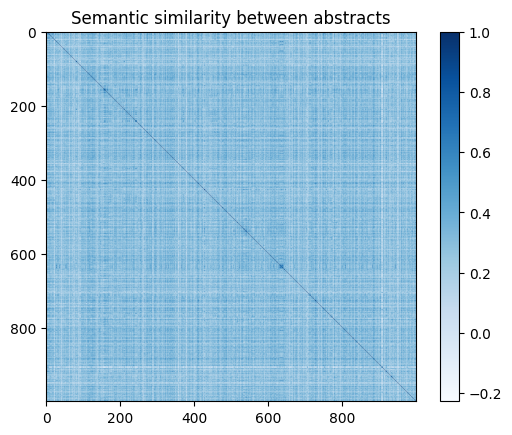

In [17]:
plt.imshow(similarity_embed, cmap='Blues') 
plt.title("Semantic similarity between abstracts") 
plt.colorbar() 
plt.show()
#картинка уже интересная и выглядит так, как будто имеет какой-то смысл

## Сравнение результатов

Пропробуем сравнить результаты TF-IDF и эмбеддиргов.

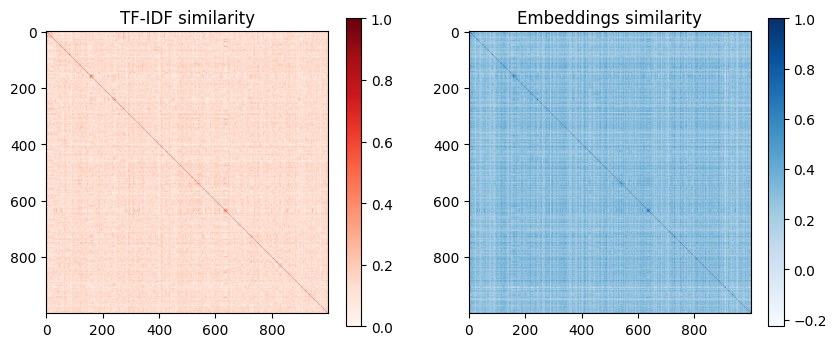

In [18]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(similarity_tfidf_1, cmap='Reds')
plt.title("TF-IDF similarity")
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(similarity_embed, cmap='Blues')
plt.title("Embeddings similarity")
plt.colorbar()
plt.show()

Интересно, видно, что есть какие-то различия, но толком ничего непонятно.
Сравним топ-1 или топ-3 самых похожих текстов:

In [19]:
top_n = 1
n_texts = 1000
for i in range(n_texts):
    tfidf_top = similarity_tfidf_1[i].argsort()[-top_n-1:-1][::-1]  # исключаем сам текст
    embed_top = similarity_embed[i].argsort()[-top_n-1:-1][::-1]
    print(f"Text {i}:")
    print(f"  TF-IDF top {top_n}: {tfidf_top}")
    print(f"  Embeddings top {top_n}: {embed_top}")

Text 0:
  TF-IDF top 1: [852]
  Embeddings top 1: [324]
Text 1:
  TF-IDF top 1: [844]
  Embeddings top 1: [184]
Text 2:
  TF-IDF top 1: [561]
  Embeddings top 1: [797]
Text 3:
  TF-IDF top 1: [8]
  Embeddings top 1: [8]
Text 4:
  TF-IDF top 1: [481]
  Embeddings top 1: [20]
Text 5:
  TF-IDF top 1: [6]
  Embeddings top 1: [6]
Text 6:
  TF-IDF top 1: [5]
  Embeddings top 1: [5]
Text 7:
  TF-IDF top 1: [420]
  Embeddings top 1: [420]
Text 8:
  TF-IDF top 1: [3]
  Embeddings top 1: [3]
Text 9:
  TF-IDF top 1: [3]
  Embeddings top 1: [3]
Text 10:
  TF-IDF top 1: [757]
  Embeddings top 1: [492]
Text 11:
  TF-IDF top 1: [838]
  Embeddings top 1: [456]
Text 12:
  TF-IDF top 1: [304]
  Embeddings top 1: [430]
Text 13:
  TF-IDF top 1: [364]
  Embeddings top 1: [199]
Text 14:
  TF-IDF top 1: [458]
  Embeddings top 1: [7]
Text 15:
  TF-IDF top 1: [451]
  Embeddings top 1: [894]
Text 16:
  TF-IDF top 1: [20]
  Embeddings top 1: [20]
Text 17:
  TF-IDF top 1: [19]
  Embeddings top 1: [327]
Text 18:
 

Как это понимать? Например, для Text 0 наиболее похожий текст согласно TF-IDF (буквальное совпадение слов) - это текст 852. А по смыслу (Embeddings) он наиболее схож с текстом 324.
Для текстов 3 и 5 саме похожие тексты оба метода нашли одинаково, для многих других нет.

In [20]:
# Пример разных результатов метода
print("**Text 0:**", df.summary[0])
print("**TF-IDF most similar:**", df.summary[852])
print("**Embeddings most similar:**", df.summary[324])

**Text 0:** The Antarctic Muon And Neutrino Detector Array (AMANDA) is a high-energy
neutrino telescope operating at the geographic South Pole. It is a lattice of
photo-multiplier tubes buried deep in the polar ice between 1500m and 2000m.
The primary goal of this detector is to discover astrophysical sources of high
energy neutrinos. A high-energy muon neutrino coming through the earth from the
Northern Hemisphere can be identified by the secondary muon moving upward
through the detector. The muon tracks are reconstructed with a maximum
likelihood method. It models the arrival times and amplitudes of Cherenkov
photons registered by the photo-multipliers. This paper describes the different
methods of reconstruction, which have been successfully implemented within
AMANDA. Strategies for optimizing the reconstruction performance and rejecting
background are presented. For a typical analysis procedure the direction of
tracks are reconstructed with about 2 degree accuracy.
**TF-IDF most si

In [21]:
# пример одинакового результата:
print("**Text 3:**", df.summary[3])
print("**TF-IDF and Embeddings most similar:**", df.summary[8])

**Text 3:** The DARWIN mission is an Infrared free flying interferometer mission based on
the new technique of nulling interferometry. Its main objective is to detect
and characterize other Earth-like planets, analyze the composition of their
atmospheres and their capability to sustain life, as we know it. DARWIN is
currently in definition phase. This PhD work that has been undertaken within
the DARWIN team at the European Space Agency (ESA) addresses two crucial
aspects of the mission. Firstly, a DARWIN target star list has been established
that includes characteristics of the target star sample that will be critical
for final mission design, such as, luminosity, distance, spectral
classification, stellar variability, multiplicity, location and radius of the
star. Constrains were applied as set by planet evolution theory and mission
architecture. Secondly, a number of alternative mission architectures have been
evaluated on the basis of interferometer response as a function of wavelen

In [22]:
pip install umap-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: /home/vtokareva/Projects/AI_onto/env_prod/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
# Попробуем применить применить UMAP / t-SNE

In [24]:
from sklearn.manifold import TSNE
import umap

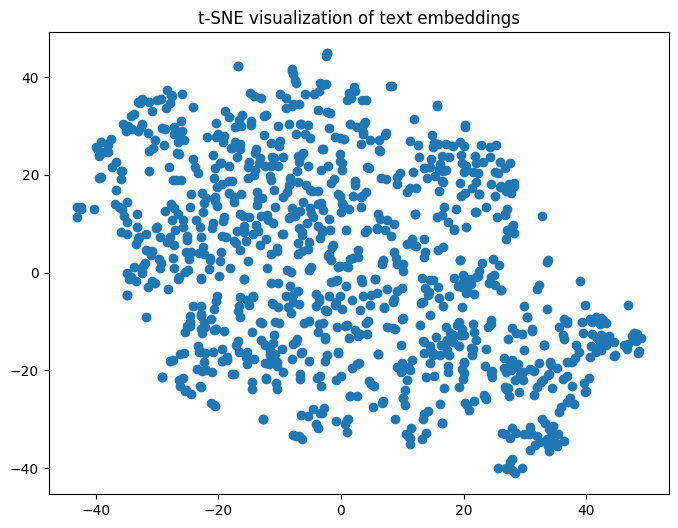

In [25]:
# embeddings - твой массив эмбеддингов (N_texts, embedding_dim)
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)  # результат - 2D координаты для каждого текста

# рисуем
plt.figure(figsize=(8,6))
plt.scatter(embeddings_2d[:,0], embeddings_2d[:,1])

# подписи к точкам (необязательно, если много текстов - у нас с 1000 текстов свыходит грязненько)
# for i, txt in enumerate(df['summary']):
#     plt.annotate(str(i), (embeddings_2d[i,0], embeddings_2d[i,1]))

plt.title("t-SNE visualization of text embeddings")
plt.show()

/home/vtokareva/Projects/AI_onto/env_prod/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


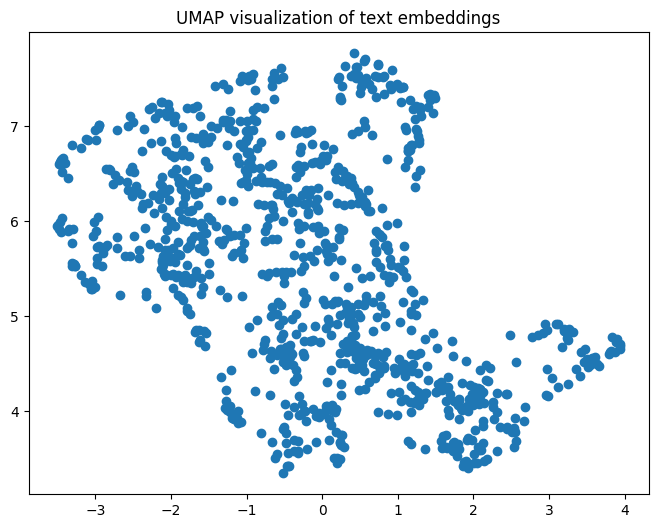

In [26]:
# UMAP визуализация
reducer = umap.UMAP(n_components=3, random_state=42)
embeddings_umap = reducer.fit_transform(embeddings)

plt.figure(figsize=(8,6))
plt.scatter(embeddings_umap[:,0], embeddings_umap[:,1])

# for i, txt in enumerate(texts):
#     plt.annotate(str(i), (embeddings_umap[i,0], embeddings_umap[i,1]))

plt.title("UMAP visualization of text embeddings")
plt.show()

Визуально можно заметить два кластера. И это у нас было тексты с одной тематикой. Можно проверить на всех данных, будут ли хорошо кластеризоваться по группам тексты с разными `subject`.

## Куда дальше?

- Лучше разобраться, как именно считают косинусное сходство
- Кто такие n-граммы
- Как конкретно алгоритмически работают TSNE и UMAP
- Попробовать эмбеддинги с другими моделями

Дима:
- Научиться работать с более мощными эмбеддингами (infinity)
- на машине "Моря данных" (кредиты будут)
- начать с 1000 записей? лучше с разношёрстным сэмплом